<a href="https://colab.research.google.com/github/sgkmills/python-stock-analysis-projects/blob/main/OptionTradingApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py_vollib
!pip install mibian
!pip install options
!pip install QuantLib-Python
!pip install mplfinance

  Using cached QuantLib_Python-1.18-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached QuantLib-1.36-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
Using cached QuantLib_Python-1.18-py2.py3-none-any.whl (1.4 kB)
Using cached QuantLib-1.36-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.6 MB)


[*********************100%***********************]  1 of 1 completed



Excluded HV Rows due to earning dates: 0, days_before_buffer: 0, days_after_buffer=0


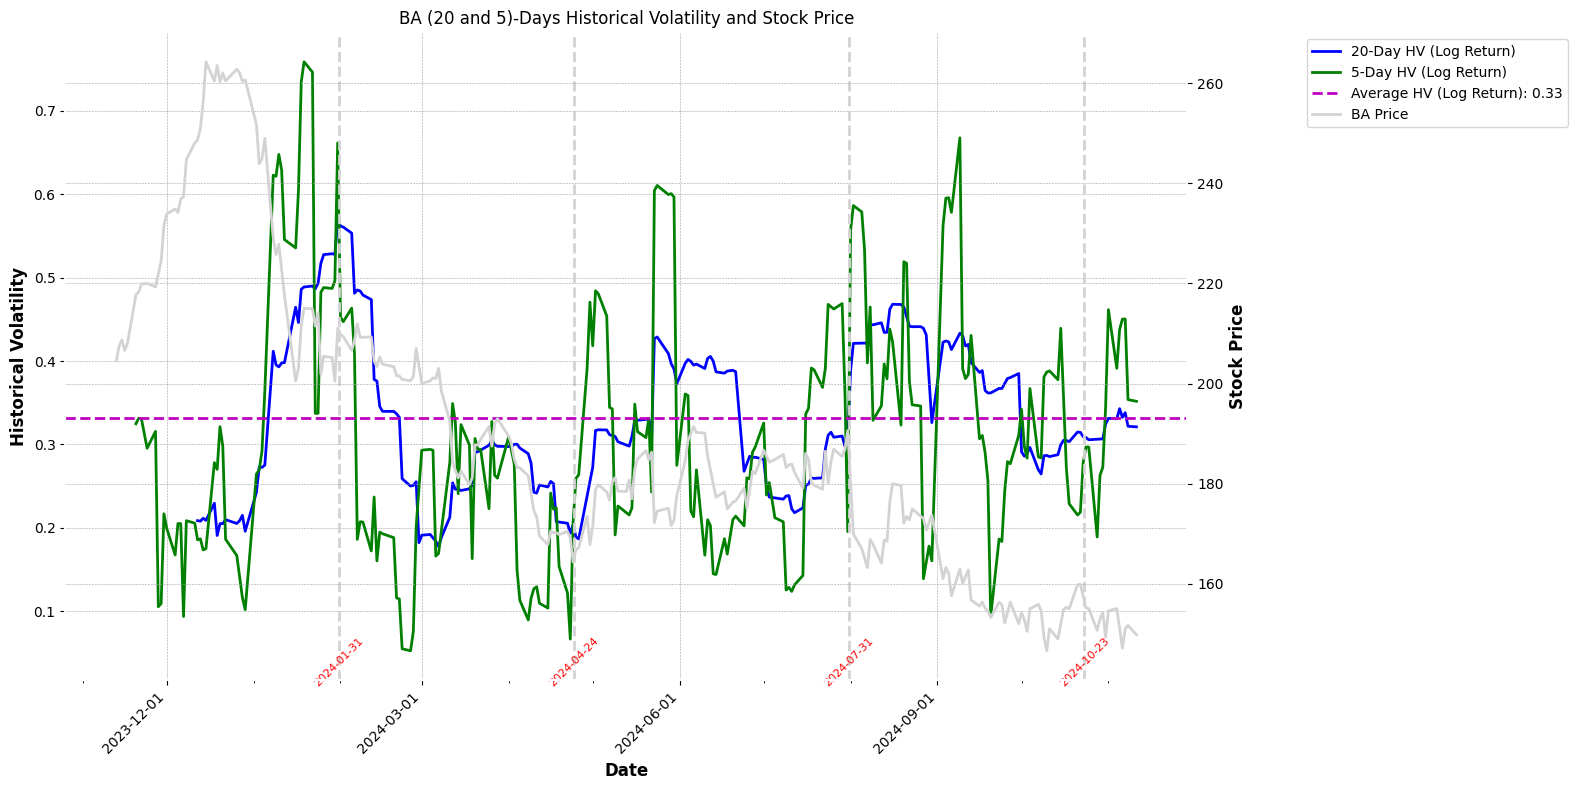

[*********************100%***********************]  1 of 1 completed



Excluded HV Rows due to earning dates: 0, days_before_buffer: 0, days_after_buffer=0


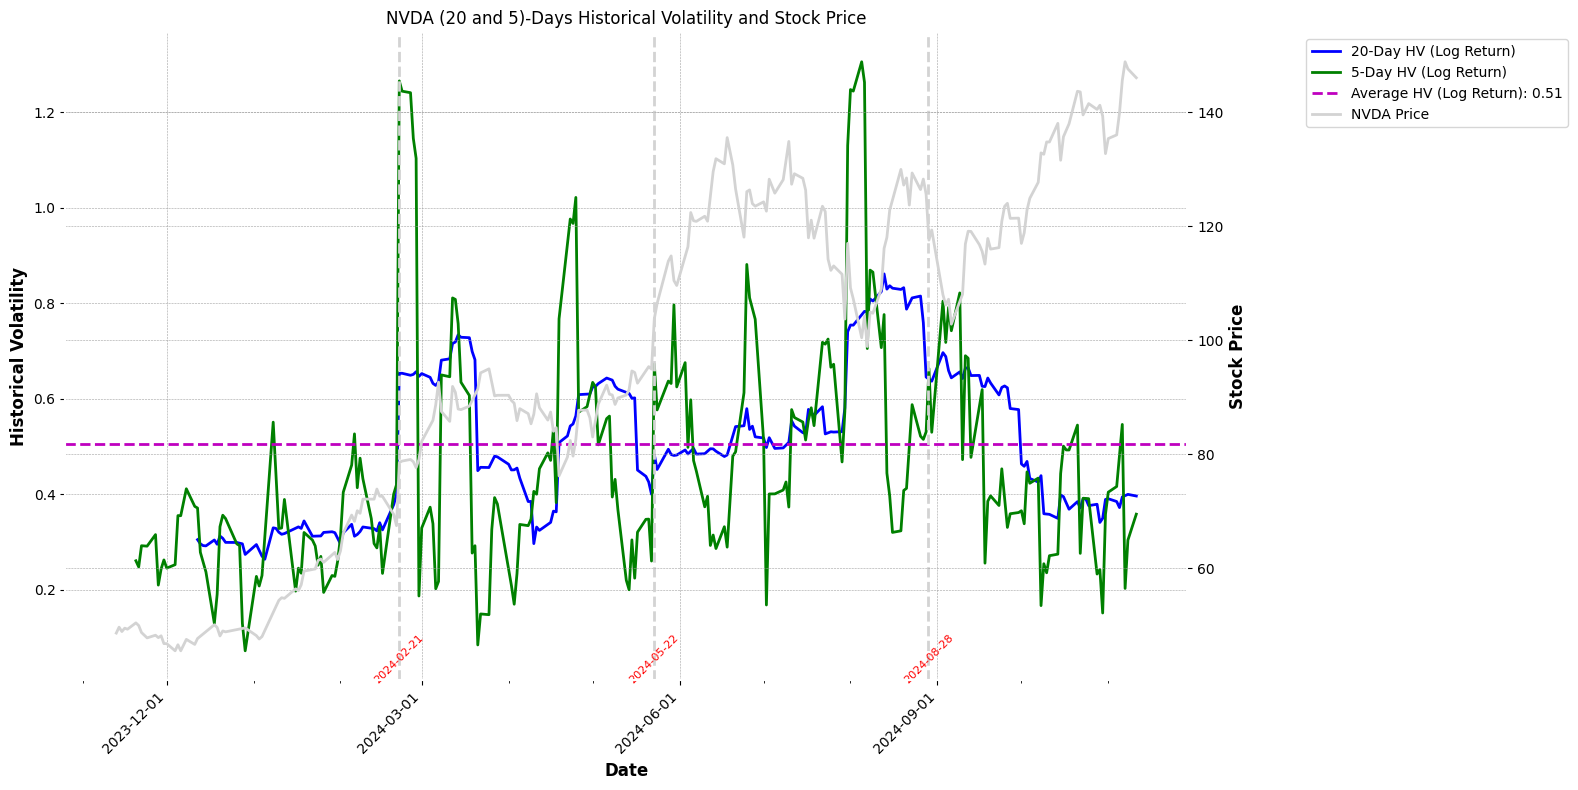

[*********************100%***********************]  1 of 1 completed



Excluded HV Rows due to earning dates: 0, days_before_buffer: 0, days_after_buffer=0


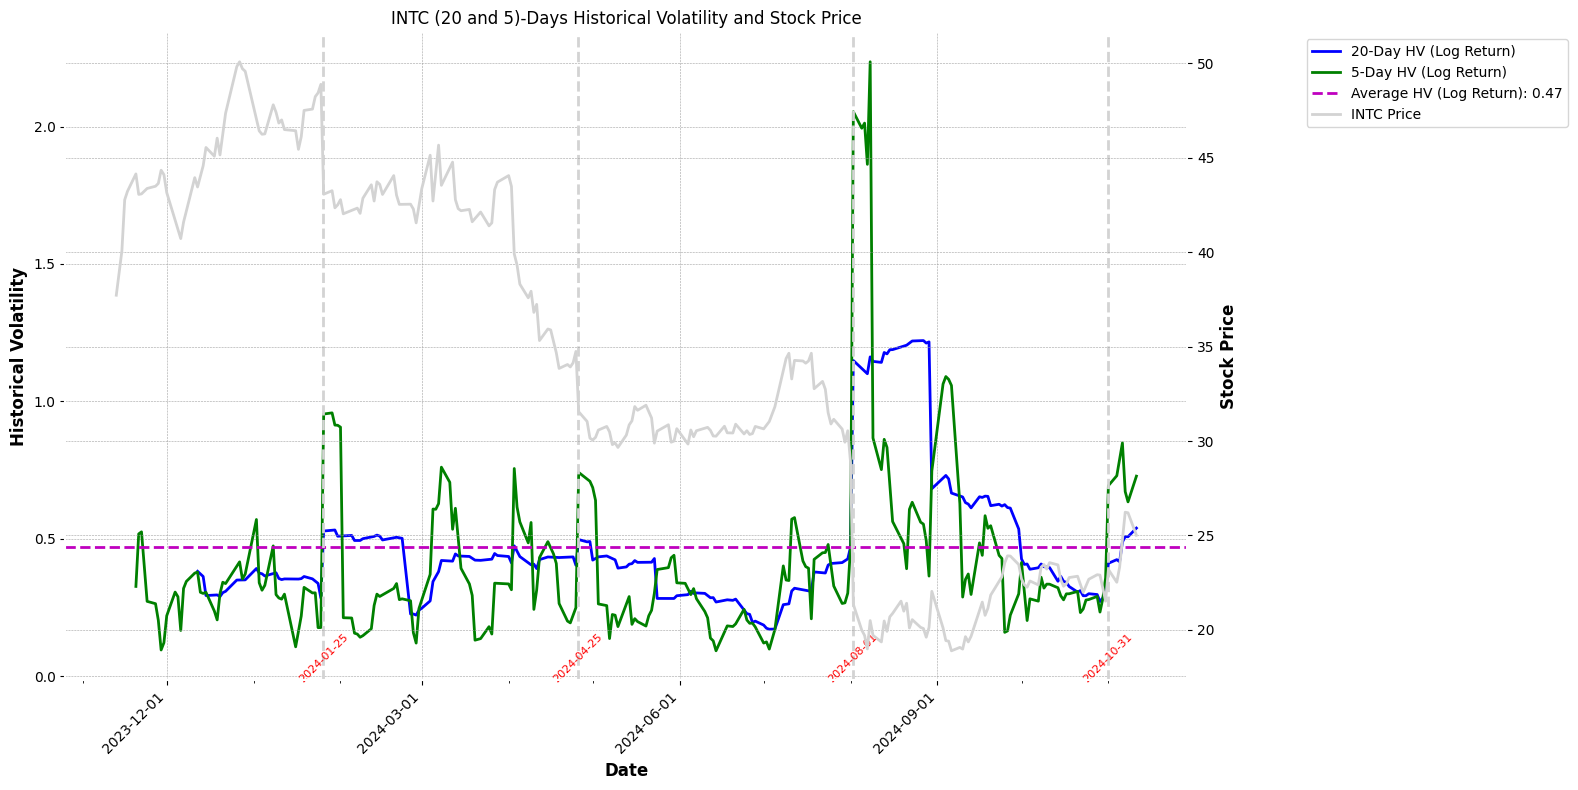

Stock,Date,First OTM IV,Last ITM IV,Current HV N Day Log,Volatility Difference (%)
BA,2024-12-27,0.381598,0.411261,0.321079,123.47
NVDA,2024-12-27,0.503972,0.505986,0.396584,127.33
INTC,2024-12-27,0.523442,0.530278,0.538890,97.77




Average First OTM IV: 0.469671
Average Last ITM IV: 0.482508
Average Current HV (20-day Log): 0.418851
Average Volatility Difference: 116.189221


In [5]:
import os
import shutil
import yfinance as yf
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf
import matplotlib.dates as mdates
import mibian
import QuantLib as ql
import py_vollib.black_scholes_merton.greeks.analytical as bsm_greeks
import py_vollib.black_scholes.greeks.analytical as bs_greeks
from datetime import datetime, timedelta
#Import display and HTML functions
from IPython.display import display, HTML
from tabulate import tabulate
from prettytable import PrettyTable
from termcolor import colored
import logging

######################################################################################################################################
#                         ----------------------  USER DEFINED FUNCTIONS BELOW   ---------------------------                         #
######################################################################################################################################

# Save data to CSV
def save_data_to_csv(data, filename, save_file=False, printFilename=False):
    if save_file:
        # Check if the data is a dictionary
        if isinstance(data, dict):
            # Convert dictionary to DataFrame
            data = pd.DataFrame(list(data.items()), columns=['Key', 'Value'])

        # Check if the data is a DataFrame and then save
        if isinstance(data, pd.DataFrame):
            data.to_csv(filename, index=False)
            if  printFilename:
                print(f"Saved {filename}")
        else:
            print("Unsupported data type.")

# Function to save CSV with German localization
def save_csv_german_localized(data, filename,  save_file=False, printFilename=False):
    if save_file:
        # Check if the data is a dictionary
        if isinstance(data, dict):
            # Convert dictionary to DataFrame
            data = pd.DataFrame(list(data.items()), columns=['Key', 'Value'])

        # Check if the data is a DataFrame and then save
        if isinstance(data, pd.DataFrame):
            # Convert numbers to string with comma as decimal separator, Apply the function column-wise using apply
            data_localized = data.apply(lambda col: col.map(lambda x: f"{x:.4f}".replace('.', ',') if isinstance(x, (int, float)) else x))

            # Save CSV with semicolon as the delimiter
            data_localized.to_csv(filename, sep=';', decimal=',')
            if  printFilename:
                print(f"Saved localized CSV as {filename}")
        else:
            print("Unsupported data type.")

# Delete the files in the directory pass as a paramater
def delete_files(dir):
  # List all files and directories in the current directory
  directory = dir
  for filename in os.listdir(directory):
      file_path = os.path.join(directory, filename)
      try:
          # Check if it's a file or directory, then delete
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)  # Delete file or link
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)  # Delete directory
      except Exception as e:
          print(f'Failed to delete {file_path}. Reason: {e}')

# Define a function to print the colored table
def print_coloredA_volatility_differences(all_volatility_differences):
    table = PrettyTable()

    # Define the column names with some color using ANSI escape codes
    table.field_names = [
        "\033[1;34mStock\033[0m",  # Bold blue
        "\033[1;32mDate\033[0m",   # Bold green
        "\033[1;33mFirst OTM IV\033[0m",  # Bold yellow
        "\033[1;33mLast ITM IV\033[0m",   # Bold yellow
        "\033[1;35mCurrent HV N Day Log\033[0m",  # Bold magenta
        "\033[1;36mVolatility Difference (%)\033[0m"  # Bold cyan
    ]

    # Set the table style
    table.hrules = True  # Enable horizontal rules
    table.vrules = True  # Enable vertical rules
    table.border = True   # Enable the outer border
    table.padding_width = 1  # Padding between columns

    # Add rows to the table
    for entry in all_volatility_differences:
        table.add_row([
            entry['stock'],
            entry['date'],
            f"{entry['first_otm_iv']:.6f}",
            f"{entry['last_itm_iv']:.6f}",
            f"{entry['current_HV_N_day_Log']:.6f}",
            f"{entry['hv_difference']:.2f}"
        ])

    print("\nAll Volatility Differences:")
    print(table)

# Function to create a colored HTML table
def print_colored_volatility_differences(all_volatility_differences):
    # Define the table header
    headers = ["Stock", "Date", "First OTM IV", "Last ITM IV", "Current HV N Day Log", "Volatility Difference (%)"]

    # Start building the HTML table
    html = '<table style="border-collapse: collapse; width: auto;">'
    html += '<thead><tr>'

    # Add header row with colors
    for header in headers:
        html += f'<th style="background-color: #f2f2f2; color: black; padding: 5px; text-align: left; border: 1px solid #dddddd; font-weight: bold;">{header}</th>'
    html += '</tr></thead><tbody>'

    # Add data rows with colors
    for entry in all_volatility_differences:
        html += '<tr>'
        html += f'<td style="color: green; padding: 5px; border: 1px solid #dddddd; width: 80px;">{entry["stock"]}</td>'
        html += f'<td style="color: #339999; padding: 5px; border: 1px solid #dddddd; width: 120px;">{entry["date"]}</td>'
        html += f'<td style="color: #339999; padding: 5px; border: 1px solid #dddddd; width: 100px;">{entry["first_otm_iv"]:.6f}</td>'
        html += f'<td style="color: #339999; padding: 5px; border: 1px solid #dddddd; width: 100px;">{entry["last_itm_iv"]:.6f}</td>'
        html += f'<td style="color: #339999; padding: 5px; border: 1px solid #dddddd; width: 100px;">{entry["current_HV_N_day_Log"]:.6f}</td>'
        html += f'<td style="color: magenta; padding: 5px; border: 1px solid #dddddd; width: 120px;">{entry["volatility_difference"]:.2f}</td>'
        html += '</tr>'

    html += '</tbody></table>'

    # Display the HTML table
    display(HTML(html))

# Function to display a pretty table
def display_pretty_table(data, rows_to_display):
    table = PrettyTable()
    # Add the index (date) as the first column
    table.field_names = ['Date'] + data.columns.tolist()

    for index, row in data.tail(rows_to_display).iterrows():
        # Format the date and the float values
        date_str = index.strftime('%Y-%m-%d')  # Format the date
        formatted_row = [f"{value:.6f}" if isinstance(value, float) else value for value in row.values]
        table.add_row([date_str] + formatted_row)

    print(table)

# Function to beautify and display filtered calls and puts
def beautify_and_display(df, rows_to_display):
    if not df.empty:
        # Reset index to include it in the display
        df = df.reset_index()
        # Convert the DataFrame to a list of lists for tabulate
        df = df.head(rows_to_display)
        headers = df.columns.tolist()

        # Prepare data for tabulate
        table_data = df.values.tolist()

        # Use tabulate to display the table
        print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))
    else:
        print(f"Filtered Data - No data available")

def beautify_and_displayC(df, rows_to_display, title="Data Table"):
    if not df.empty:
        # Reset index to include it in the display
        df = df.reset_index()
        # Convert the DataFrame to a list of lists for tabulate
        df = df.head(rows_to_display)
        headers = df.columns.tolist()

        # Prepare data for tabulate with HTML format
        table_data = df.values.tolist()
        table_html = tabulate(table_data, headers=headers, tablefmt="html")

        # Generate HTML for expanded output with added CSS styling
        html = f"""
        <style>
            .collapsible-title {{
                display: inline-block;
                font-size: 1.2em;
                font-weight: bold;
                color: white;
                background-color: #339999;
                padding: 8px 12px;
                border: none;
                border-radius: 8px;
                cursor: pointer;
                margin: 10px 0;
                text-align: center;
            }}
            .collapsible-table table {{
                border-collapse: collapse;
                width: 100%;
                color: #e0e0e0;  /* Light text color for dark theme compatibility */
            }}
            .collapsible-table th, .collapsible-table td {{
                border: 1px solid #555;
                padding: 8px;
                text-align: left;
            }}
            .collapsible-table tr:nth-child(even) {{
                background-color: #333; /* Darker gray for even rows */
            }}
            .collapsible-table tr:nth-child(odd) {{
                background-color: #444; /* Slightly lighter gray for odd rows */
            }}
            .collapsible-table tr:hover {{
                background-color: #555; /* Highlight on hover */
            }}
            .collapsible-table th {{
                padding-top: 12px;
                padding-bottom: 12px;
                background-color: #4CAF50;
                color: white;
            }}
        </style>
        <div class="collapsible-title" onclick="this.nextElementSibling.style.display =
            this.nextElementSibling.style.display == 'none' ? 'block' : 'none';">
            {title}
        </div>
        <div class="collapsible-table" style="display: none;">
            {table_html}
        </div>
        """
        display(HTML(html))
    else:
        print("Filtered Data - No data available")

# Function to beautify and display a dataFrame
def beautify_and_display_df(data, rows_to_display=5):
    # Convert the date column if it is the index
    if isinstance(data.index, pd.DatetimeIndex):
        data = data.copy()
        data.index = data.index.strftime('%Y-%m-%d')

    styled_data = (
        data.tail(rows_to_display)
        .style.set_table_styles(
            [{'selector': 'thead th', 'props': [('background-color', '#f0f0f0'), ('color', 'black')]}]
        )
        .format({
            col: "{:.6f}" for col in data.select_dtypes(include='float').columns
        })
        .set_properties(**{'text-align': 'center'})
    )

    display(styled_data)

# Calculate the target date by adding days_to_expiration to today's date.
def calculate_target_date(days_to_expiration):
    """
    Calculate the target date by adding days_to_expiration to today's date.

    Parameters:
    days_to_expiration (int): The number of days to add to today's date.

    Returns:
    str: The target date formatted as 'YYYY-MM-DD'.
    """
    # Calculate today's date
    today = datetime.today()

    # Calculate the target date by adding days_to_expiration
    target_date = today + timedelta(days=days_to_expiration)

    # Format the target date as a string in the format 'YYYY-MM-DD'
    calculated_target_date = target_date.strftime('%Y-%m-%d')

    return calculated_target_date

def get_earnings_dates(ticker):
    stock = yf.Ticker(ticker)
    earnings_df = stock.earnings_dates
    return pd.to_datetime(earnings_df.index.to_list()).tz_convert('UTC')  # Ensure dates are in UTC

def filter_data_around_earnings(data, earnings_dates, days_before, days_after):
    mask = pd.Series([True] * len(data), index=data.index)  # Initialize mask as True for all dates
    for date in earnings_dates:
        start_date = date - pd.Timedelta(days=days_before)
        end_date = date + pd.Timedelta(days=days_after)
        mask &= ~((data.index >= start_date) & (data.index <= end_date))  # Exclude dates in buffer range
    return data[mask].copy()  # Create a copy to avoid SettingWithCopyWarning

# Define a function to calculate historical volatility
def calculate_hv(returns, window):
    # Calculate the rolling standard deviation of daily returns
    rolling_std = returns.rolling(window=window).std()
    # Annualize the volatility (multiply by sqrt(252))
    hv = rolling_std * np.sqrt(252)
    return hv

def calculate_heikin_ashi(data):
    """
    Calculate Heikin-Ashi candlestick values from stock data.

    Parameters:
    - data: DataFrame containing stock price data with columns 'Open', 'High', 'Low', 'Close'.

    Returns:
    - A DataFrame with Heikin-Ashi OHLC values.
    """
    ha_data = data[['Open', 'High', 'Low', 'Close']].copy()
    ha_data['HA_Close'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
    ha_data['HA_Open'] = ha_data['HA_Close'].shift(1)  # Initial Open is the previous bar's Close
    ha_data['HA_High'] = ha_data[['HA_Open', 'HA_Close', 'High']].max(axis=1)
    ha_data['HA_Low'] = ha_data[['HA_Open', 'HA_Close', 'Low']].min(axis=1)

    # Set the first HA_Open to be the stock's actual first Open value
    ha_data.iloc[0, ha_data.columns.get_loc('HA_Open')] = data['Open'].iloc[0]

    # Flatten columns if needed (optional)
    ha_data.columns = [col[0] if isinstance(col, tuple) else col for col in ha_data.columns]

    return ha_data[['HA_Open', 'HA_High', 'HA_Low', 'HA_Close']]


# Calculates historical volatility (HV) for a given stock and saves the data to a CSV file
def calculate_and_save_hv(stock, period, time_interval,rows_to_display=5,  no_of_HV_days=20, no_of_HV2_days=5, days_before_buffer=3, days_after_buffer=3, debug_mode=False):
    """
    Calculates historical volatility (HV) for a given stock and saves the data to a CSV file.

    Parameters:
    - stock: Stock symbol (e.g., 'AAPL')
    - period: The period over which to retrieve data (e.g., '1y', '3mo')
    - time_interval: Time interval for data (e.g., '1d', '1wk')
    - rows_to_display: Number of rows to display from the DataFrame (default: 5)
    - no_of_HV_days: Number of days to calculate historical volatility, long value (default: 20)
    - no_of_HV2_days: Number of days to calculate historical volatility, short value (default: 5)
    - days_before_buffer: Number of days before the earnings date to exclude data (default: 3)
    - days_after_buffer: Number of days after the earnings date to exclude data (default: 3)
    - debug_mode: Boolean flag for printing debug information (default: False)

    Returns:
    - A dictionary containing the HV data, averages, and other relevant information.
    """

    hv_data = {}  # Dictionary to store HV data for each no_of_HV_days and no_of_HV2_days
    # Download the historical data from Yahoo Finance
    data = yf.download(stock, period=period, interval=time_interval)
    data.index = pd.to_datetime(data.index)  # Ensure datetime format

    earnings_dates = get_earnings_dates(stock)
    #print(f'days_before_buffer: {days_before_buffer}, days_after_buffer={days_after_buffer}')
    #print(f"Data--Number of rows: {data.shape[0]}, Number of columns:, {data.shape[1]}")
    #print(f'data={data}')
    filtered_price_data = filter_data_around_earnings(data, earnings_dates, days_before_buffer, days_after_buffer)

    #print(f"filtered_price_data--Number of rows: {filtered_price_data.shape[0]}, Number of columns:, {filtered_price_data.shape[1]}")
    #print(f'filtered_price_data={filtered_price_data}')

    # Identify and display excluded rows
    excluded_rows = data.loc[data.index.difference(filtered_price_data.index)]
    print(f"\nExcluded HV Rows due to earning dates: {excluded_rows.shape[0]}, days_before_buffer: {days_before_buffer}, days_after_buffer={days_after_buffer}")
    #print(f'excluded_rows={excluded_rows}')

    # Calculate daily returns (percentage change between consecutive close prices)
    filtered_price_data.loc[:, 'Daily_Return'] = filtered_price_data['Adj Close'].pct_change()
    filtered_price_data.loc[:, 'Daily_Return_Log'] = np.log(filtered_price_data['Adj Close'] / filtered_price_data['Adj Close'].shift(1))


    # Get the stock prices for use outside the function
    stock_prices = filtered_price_data['Adj Close']

    # Calculate Heikin-Ashi values
    heikin_ashi_df = calculate_heikin_ashi(filtered_price_data)
    #print(f'heikin_ashi_df={heikin_ashi_df}')

    # Function to calculate historical volatility (rolling standard deviation)
    def calculate_hv(returns, window):
        return returns.rolling(window=window).std() * np.sqrt(252)

    # Calculate the 'no_of_HV_days'' rolling standard deviation of daily returns (historical volatility)
    filtered_price_data.loc[:, f'HV_{no_of_HV_days}_Day'] = calculate_hv(filtered_price_data['Daily_Return'], no_of_HV_days)
    filtered_price_data.loc[:, f'HV_{no_of_HV_days}_Day_Log'] = calculate_hv(filtered_price_data['Daily_Return_Log'], no_of_HV_days)

    # Calculate the 'no_of_HV2_days'' rolling standard deviation of daily returns (historical volatility) for hv2
    filtered_price_data.loc[:, f'HV_{no_of_HV2_days}_Day'] = calculate_hv(filtered_price_data['Daily_Return'], no_of_HV2_days)
    filtered_price_data.loc[:, f'HV_{no_of_HV2_days}_Day_Log'] = calculate_hv(filtered_price_data['Daily_Return_Log'], no_of_HV2_days)

    # Save data to a CSV file
    filename = f"filtered_price_data_{stock}_HV_Days-{no_of_HV_days}_period-{period}_{time_interval}.csv"
    filename2 = f"filtered_price_data_{stock}_HV_Days-{no_of_HV2_days}_period-{period}_{time_interval}.csv"
    #data.to_csv(filename)
    if debug_mode and detailed_output:
        print(f"\nData saved to {filename}\n")
        print(f"\nData saved to {filename2}\n")

    # Drop rows with NaN values (due to rolling calculation)
    stock_hv_N_day = filtered_price_data[[f'HV_{no_of_HV_days}_Day', f'HV_{no_of_HV_days}_Day_Log']].dropna()
    stock_hv2_N_day = filtered_price_data[[f'HV_{no_of_HV2_days}_Day', f'HV_{no_of_HV2_days}_Day_Log']].dropna()

    formatted_earnings_dates = [date.strftime('%Y-%m-%d') for date in earnings_dates]
    #print(f'earnings_dates={formatted_earnings_dates}')

    # Get the range of dates from the historical volatility data
    min_hv_date = stock_hv_N_day.index.min()
    max_hv_date = stock_hv_N_day.index.max()
    min_hv2_date = stock_hv2_N_day.index.min()
    max_hv2_date = stock_hv2_N_day.index.max()

    # Filter earnings dates to only include those within the range
    filtered_earnings_dates = earnings_dates[(earnings_dates.tz_convert('UTC').normalize() >= min_hv_date.tz_convert('UTC').normalize()) & (earnings_dates.tz_convert('UTC').normalize() <=max_hv_date.tz_convert('UTC').normalize())]
    formatted_filtered_earnings_dates = [date.strftime('%Y-%m-%d') for date in filtered_earnings_dates]
    #print(f'max_hv_date= {max_hv_date}, filtered earnings_dates={formatted_filtered_earnings_dates}\n')

    # Store the DataFrame in the dictionary with a key based on no_of_HV_days
    hv_data[f'stock_hv_{no_of_HV_days}_day'] = filtered_price_data[[f'HV_{no_of_HV_days}_Day', f'HV_{no_of_HV_days}_Day_Log']].dropna()
    hv_data[f'stock_hv_{no_of_HV2_days}_day'] = filtered_price_data[[f'HV_{no_of_HV2_days}_Day', f'HV_{no_of_HV2_days}_Day_Log']].dropna()

    # Calculate the average historical volatility over the period using the dictionary
    average_hv = hv_data[f'stock_hv_{no_of_HV_days}_day'][f'HV_{no_of_HV_days}_Day'].mean()
    average_hv_Log = hv_data[f'stock_hv_{no_of_HV_days}_day'][f'HV_{no_of_HV_days}_Day_Log'].mean()
    average_hv2 = hv_data[f'stock_hv_{no_of_HV2_days}_day'][f'HV_{no_of_HV2_days}_Day'].mean()
    average_hv2_Log = hv_data[f'stock_hv_{no_of_HV2_days}_day'][f'HV_{no_of_HV2_days}_Day_Log'].mean()

    #current_stock_price
    current_stock_price = filtered_price_data['Adj Close'].iloc[-1].values[0]

    # Plot HV and Heikin-Ashi chart with stock price
    #plot_iv_and_heikin_ashi(stock_hv_N_day=stock_hv_N_day, stock_prices=stock_prices, no_of_HV_days=no_of_HV_days, average_hv=average_hv, average_hv_Log=average_hv_Log, stock=stock, heikin_ashi_df=heikin_ashi_df)

    # Display the last # of rows, specified in 'rows_to_display' of the HV data if debug mode is on
    if debug_mode and detailed_output:
        html_output = f"""
        <h3 style="color:green; display: inline;">Historical Volatility for {no_of_HV_days} Days (Last {rows_to_display} Rows):</h3>
        """
        display(HTML(html_output))

        beautify_and_display_df(hv_data[f'stock_hv_{no_of_HV_days}_day'], rows_to_display)

    # Return pertinent data in a dictionary
    return {
        'current_stock_price': current_stock_price,
        f'stock_hv_{no_of_HV_days}_day': hv_data[f'stock_hv_{no_of_HV_days}_day'],
        'average_hv': average_hv,
        'average_hv_Log': average_hv_Log,
        'no_of_HV_days': no_of_HV_days,
        f'stock_hv_{no_of_HV2_days}_day': hv_data[f'stock_hv_{no_of_HV2_days}_day'],
        'average_hv2': average_hv2,
        'average_hv2_Log': average_hv2_Log,
        'no_of_HV2_days': no_of_HV2_days,
        'filename': filename,
        'filename2': filename2,
        'stock_prices': stock_prices
    }

# Calculate the upper and lower price range based on historical volatility (HV
def calculate_price_range(current_price, hv, days=20):
    """
    Calculate the upper and lower price range based on historical volatility (HV).

    Parameters:
    - current_price: The current stock price.
    - hv: Historical volatility (annualized, expressed as a decimal).
    - days: The number of days to project (default is 20).

    Returns:
    - A tuple with (lower_range, upper_range).
    """
    # Convert HV from annualized to daily
    daily_volatility = hv / np.sqrt(252)  # 252 trading days in a year

    # Calculate the expected price range using the daily volatility
    expected_change = daily_volatility * np.sqrt(days)

    # Calculate the lower and upper bounds based on log returns
    lower_bound = current_price * np.exp(-expected_change)
    upper_bound = current_price * np.exp(expected_change)

    return lower_bound, upper_bound

# Retrieve the Option Chain for a single stock
def get_Option_Chain(stock_symbol, target_date, current_stock_price):
    # Create a Ticker object
    ticker = yf.Ticker(stock_symbol)

    # Get expiration dates for the options
    expiration_dates = ticker.options
    print("\n\nget_Option_Chain- Available expiration dates:", expiration_dates)

    # Convert target_date and expiration_dates to datetime objects
    target_date = datetime.strptime(target_date, '%Y-%m-%d')
    expiration_dates_dt = [datetime.strptime(date, '%Y-%m-%d') for date in expiration_dates]

    # Find the nearest expiration date
    closest_date = min(expiration_dates_dt, key=lambda x: abs(x - target_date))
    chosen_date = closest_date.strftime('%Y-%m-%d')
    print(f"Nearest expiration date to {target_date.strftime('%Y-%m-%d')}: {chosen_date}")

    # Get the option chain for the chosen expiration date
    option_chain = ticker.option_chain(chosen_date)

    # Access calls and puts data
    calls = option_chain.calls
    puts = option_chain.puts
    # Find the first OTM call option (inTheMoney = False)
    first_otm_call = calls[calls['inTheMoney'] == False].head(1)
    # Find the first OTM put option (inTheMoney = False)
    first_itm_put = puts[puts['inTheMoney'] == True].head(1)

    return calls, puts, chosen_date, first_otm_call, first_itm_put

# Display the Option Chain for a single stock
def display_option_chain_info(calls, puts, rows_to_display):
    # Display the first few rows of calls and puts data
    print("\nCalls:")
    print(calls.head(rows_to_display))

    # Find the first OTM call option (where inTheMoney is False)
    first_otm_call = calls[calls['inTheMoney'] == False].head(1)

    # Print the first OTM call option details if available
    if not first_otm_call.empty:
        print("\nFirst OTM Call Option:")
        print(first_otm_call)
    else:
        print("\nNo OTM Call Options available.")

    print("\nPuts:")
    print(puts.head(rows_to_display))

    # Find the first ITM put option (where inTheMoney is True)
    first_itm_put = puts[puts['inTheMoney'] == True].head(1)

    # Print the first ITM put option details if available
    if not first_itm_put.empty:
        print("\nFirst ITM Put Option:")
        print(first_itm_put)
    else:
        print("\nNo ITM Put Options available.")

# Retrieve the Option Chain for multiple stocks
def get_option_chains_for_date_range(stock_symbol, target_date):
    # Create a Ticker object
    ticker = yf.Ticker(stock_symbol)

    # Get all expiration dates for the options
    expiration_dates = ticker.options
    if detailed_output:
      html_output = f"""
      <h3 style="color:#339999;"">Available expiration dates:</h3>
      """
      display(HTML(html_output))
      print(f"\t\033[1m{expiration_dates}\033[0m")

    # Convert target_date and expiration_dates to datetime objects
    target_date = datetime.strptime(target_date, '%Y-%m-%d').date()
    today = datetime.today().date()
    expiration_dates_dt = [datetime.strptime(date, '%Y-%m-%d').date() for date in expiration_dates]

    # Filter expiration dates that are between today and the target_date
    filtered_dates = [date for date in expiration_dates_dt if today <= date <= target_date]

    # Check if filtered_dates does not contain target_date_dt
    if target_date not in filtered_dates:
        # Find the next expiration date after the target_date_dt
        next_expiration_date = None
        for date in expiration_dates_dt:
            if date > target_date:
                next_expiration_date = date
                break

        # Check if filtered_dates does not contain the target_date and adjust if needed
        if target_date not in filtered_dates:
            # If there is a next expiration date, check the distances
            if next_expiration_date:
                last_filtered_date = filtered_dates[-1] if filtered_dates else None
                # Compare distances between target_date and the closest dates
                if last_filtered_date and abs((target_date - last_filtered_date).days) <= abs((next_expiration_date - target_date).days):
                    # If the target_date is closer to the last_filtered_date, don't add next_expiration_date
                    pass
                else:
                    # Otherwise, add the next expiration date
                    filtered_dates.append(next_expiration_date)

    # Sort the filtered dates to maintain order
    filtered_dates.sort()
    if detailed_output:
      html_output = f"""
      <h3 style="color:#339999;"">Targeted date:</h3>
      """
      display(HTML(html_output))
      print(f"\t\033[1m{target_date}\033[0m, Filtered expiration dates between \033[1m{today}\033[0m and \033[1m{target_date}\033[0m: \033[1m{[date.strftime('%Y-%m-%d') for date in filtered_dates]}\033[0m")

    # Dictionary to store option chain data for each expiration date
    option_chains = {}

    # Loop through each filtered expiration date and retrieve the option chain
    for date in filtered_dates:
        chosen_date = date.strftime('%Y-%m-%d')
        #print(f"Fetching option chain for expiration date: {chosen_date}")

        # Get the option chain for the chosen expiration date
        option_chain = ticker.option_chain(chosen_date)

        # Access calls and puts data
        calls = option_chain.calls
        puts = option_chain.puts

        # Store the data in the dictionary
        option_chains[chosen_date] = {'calls': calls, 'puts': puts}


    return option_chains

# Initialize Greek columns in option_chains before passing to calculate_greeks
def initialize_columns(option_data):
    greek_columns = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
    for df in [option_data['calls'], option_data['puts']]:
        for col in greek_columns:
            if col not in df.columns:
                df[col] = np.nan

# Calculate the greeks for the Option Chains using py_vollib
def calculate_greeks(calls, puts, current_stock_price, risk_free_rate, expiration_date, dividend_yield=0):
    # Convert the expiration date to a datetime object and calculate time to expiration in years

    today = datetime.today().date()
    expiration_date = datetime.strptime(expiration_date, '%Y-%m-%d').date()
    time_to_expiration = (expiration_date - today).days / 365.0
    #print(f'calls={calls}')

    # Select the appropriate model based on whether the stock pays dividends
    if dividend_yield > 0:
        model_greeks = bsm_greeks  # Black-Scholes-Merton
    else:
        model_greeks = bs_greeks  # Black-Scholes

    # Calculate Greeks for calls
    for index, row in calls.iterrows():
        S = current_stock_price
        K = row['strike']
        T = time_to_expiration
        r = risk_free_rate
        sigma = row['impliedVolatility']
        #print(f'S:{S}, K:{K}, T:{T}, r:{r}, sigma:{sigma}')

        # Check if sigma is valid and above a minimum threshold
        if np.isnan(sigma) or sigma <= 0:
            continue  # Skip this row if sigma is not valid

        # Avoid division errors in the model by ensuring sigma is not too small
        sigma = max(sigma, 1e-6)
        #print(f'S:{S}, K:{K}, T:{T}, r:{r}, *sigma:{sigma}')

        if dividend_yield > 0:
            # Using Black-Scholes-Merton model (requires dividend yield)
            calls.at[index, 'Delta'] = bsm_greeks.delta('c', S, K, T, r, sigma, dividend_yield)
            calls.at[index, 'Gamma'] = bsm_greeks.gamma('c', S, K, T, r, sigma, dividend_yield)
            calls.at[index, 'Theta'] = bsm_greeks.theta('c', S, K, T, r, sigma, dividend_yield)
            calls.at[index, 'Vega'] = bsm_greeks.vega('c', S, K, T, r, sigma, dividend_yield)
            calls.at[index, 'Rho'] = bsm_greeks.rho('c', S, K, T, r, sigma, dividend_yield)
        else:
            # Using Black-Scholes model (does not require dividend yield)
            calls.at[index, 'Delta'] = bs_greeks.delta('c', S, K, T, r, sigma)
            #calls.at[index, 'Delta'], calls.at[index, 'Gamma'], calls.at[index, 'Theta'], vega, rho =  binomial_tree_greeks(S, K, T, r, sigma, 100, 'c', dividend_yield)
            calls.at[index, 'Gamma'] = bs_greeks.gamma('c', S, K, T, r, sigma)
            calls.at[index, 'Theta'] = bs_greeks.theta('c', S, K, T, r, sigma)
            calls.at[index, 'Vega'] = bs_greeks.vega('c', S, K, T, r, sigma)
            calls.at[index, 'Rho'] = bs_greeks.rho('c', S, K, T, r, sigma)


    # Calculate Greeks for puts
    for index, row in puts.iterrows():
        S = current_stock_price
        K = row['strike']
        T = time_to_expiration
        r = risk_free_rate
        sigma = row['impliedVolatility']

        # Check if sigma is valid and above a minimum threshold
        if np.isnan(sigma) or sigma <= 0:
            continue  # Skip this row if sigma is not valid

        # Avoid division errors in the model by ensuring sigma is not too small
        sigma = max(sigma, 1e-6)

        if dividend_yield > 0:
            puts.at[index, 'Delta'] = bsm_greeks.delta('p', S, K, T, r, sigma, dividend_yield)
            puts.at[index, 'Gamma'] = bsm_greeks.gamma('p', S, K, T, r, sigma, dividend_yield)
            puts.at[index, 'Theta'] = bsm_greeks.theta('p', S, K, T, r, sigma, dividend_yield)
            puts.at[index, 'Vega'] = bsm_greeks.vega('p', S, K, T, r, sigma, dividend_yield)
            puts.at[index, 'Rho'] = bsm_greeks.rho('p', S, K, T, r, sigma, dividend_yield)
        else:
            puts.at[index, 'Delta'] = bs_greeks.delta('p', S, K, T, r, sigma)
            puts.at[index, 'Gamma'] = bs_greeks.gamma('p', S, K, T, r, sigma)
            puts.at[index, 'Theta'] = bs_greeks.theta('p', S, K, T, r, sigma)
            puts.at[index, 'Vega'] = bs_greeks.vega('p', S, K, T, r, sigma)
            puts.at[index, 'Rho'] = bs_greeks.rho('p', S, K, T, r, sigma)

    # Convert all Greek columns in both DataFrames to float (decimal values)
    greek_columns = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
    for df in [calls, puts]:
        for col in greek_columns:
            df[col] = df[col].astype(float)

    # Return the calls and puts DataFrames with Greeks and other specified columns
    return calls[['strike', 'bid', 'ask', 'lastPrice', 'volume', 'openInterest', 'inTheMoney', 'impliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy(), \
           puts[['strike', 'bid', 'ask', 'lastPrice', 'volume', 'openInterest', 'inTheMoney', 'impliedVolatility','Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy()

# Calculate greeks using mibian
def calculate_greeks1(calls, puts, current_stock_price, risk_free_rate, expiration_date, dividend_yield=0):
    # Convert the expiration date to a datetime object and calculate time to expiration in years
    today = datetime.today().date()
    expiration_date = datetime.strptime(expiration_date, '%Y-%m-%d').date()
    time_to_expiration = (expiration_date - today).days / 365.0

    # Initialize columns for Greeks in both calls and puts DataFrames
    for df in [calls, puts]:
        df['Delta'] = np.nan
        df['Gamma'] = np.nan
        df['Theta'] = np.nan
        df['Vega'] = np.nan
        df['Rho'] = np.nan

    # Calculate Greeks for calls
    for index, row in calls.iterrows():
        S = current_stock_price
        K = row['strike']
        T = time_to_expiration * 365  # Mibian uses days, not years
        r = risk_free_rate * 100  # Mibian requires the risk-free rate in percentage
        sigma = row['impliedVolatility'] * 100  # Mibian requires implied volatility in percentage

        # Check if sigma is valid and above a minimum threshold
        if np.isnan(sigma) or sigma <= 0:
            continue  # Skip this row if sigma is not valid

        # Calculate Greeks using Mibian
        c = mibian.BS([S, K, r, T], volatility=sigma)
        calls.at[index, 'Delta'] = c.callDelta
        calls.at[index, 'Gamma'] = 0
        calls.at[index, 'Theta'] = c.callTheta
        calls.at[index, 'Vega'] = 0
        calls.at[index, 'Rho'] = c.callRho

    # Calculate Greeks for puts
    for index, row in puts.iterrows():
        S = current_stock_price
        K = row['strike']
        T = time_to_expiration * 365  # Mibian uses days, not years
        r = risk_free_rate * 100  # Mibian requires the risk-free rate in percentage
        sigma = row['impliedVolatility'] * 100  # Mibian requires implied volatility in percentage

        # Check if sigma is valid and above a minimum threshold
        if np.isnan(sigma) or sigma <= 0:
            continue  # Skip this row if sigma is not valid

        # Calculate Greeks using Mibian
        p = mibian.BS([S, K, r, T], volatility=sigma)
        puts.at[index, 'Delta'] = p.putDelta
        puts.at[index, 'Gamma'] = 0
        puts.at[index, 'Theta'] = p.putTheta
        puts.at[index, 'Vega'] = 0
        puts.at[index, 'Rho'] = p.putRho

    # Convert all Greek columns in both DataFrames to float (decimal values)
    greek_columns = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
    for df in [calls, puts]:
        for col in greek_columns:
            df[col] = df[col].astype(float)

    # Return the calls and puts DataFrames with Greeks and other specified columns
    return calls[['strike', 'bid', 'ask', 'lastPrice', 'volume', 'openInterest', 'inTheMoney', 'impliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy(), \
           puts[['strike', 'bid', 'ask', 'lastPrice', 'volume', 'openInterest', 'inTheMoney', 'impliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy()

# Calculate greeks using QuantLib
def calculate_greeks2(calls, puts, current_stock_price, risk_free_rate, expiration_date, dividend_yield=0):
    # Convert the expiration date to QuantLib Date and calculate time to expiration in years
    today = ql.Date().todaysDate()
    expiration_date = datetime.strptime(expiration_date, '%Y-%m-%d')
    maturity_date = ql.Date(expiration_date.day, expiration_date.month, expiration_date.year)
    if maturity_date <= today:
        raise ValueError("Expiration date must be after today's date.")

    # Initialize Greeks in both DataFrames
    for df in [calls, puts]:
        df['Delta'] = np.nan
        df['Gamma'] = np.nan
        df['Theta'] = np.nan
        df['Vega'] = np.nan
        df['Rho'] = np.nan

    # Set up the market data
    spot_price = ql.SimpleQuote(current_stock_price)
    calendar = ql.NullCalendar()

    # Ensure risk-free rate and dividend yield are wrapped in QuoteHandles
    risk_free_handle = ql.YieldTermStructureHandle(
        ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(risk_free_rate)), ql.Actual360())
    )
    dividend_yield_handle = ql.YieldTermStructureHandle(
        ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(dividend_yield)), ql.Actual360())
    )

    risk_free_handle = ql.YieldTermStructureHandle(
        ql.FlatForward(
            today,
            risk_free_rate,
            ql.Actual365Fixed()
        )
    )

    dividend_yield_handle = ql.YieldTermStructureHandle(
        ql.FlatForward(
            today,
            dividend_yield,
            ql.Actual365Fixed()
        )
    )

    for df, option_type in [(calls, ql.Option.Call), (puts, ql.Option.Put)]:
        for index, row in df.iterrows():
            K = row['strike']
            sigma = row['impliedVolatility']
            if sigma <= 0:
                continue  # Skip entries with invalid volatility

            # Set up option payoff and European exercise
            payoff = ql.PlainVanillaPayoff(option_type, K)
            european_option = ql.VanillaOption(payoff, ql.EuropeanExercise(maturity_date))

            # If spot_price is already a SimpleQuote, use it directly; otherwise, wrap it
            if isinstance(spot_price, ql.SimpleQuote):
                spot_price_handle = ql.QuoteHandle(spot_price)
            else:
                spot_price_handle = ql.QuoteHandle(ql.SimpleQuote(float(spot_price)))

            # Set up volatility handle
            volatility_handle = ql.BlackVolTermStructureHandle(
                ql.BlackConstantVol(today, calendar, ql.QuoteHandle(ql.SimpleQuote(sigma)), ql.Actual365Fixed())
            )

        # Verify types of handles
        handles = {
            "spot_price_handle": spot_price_handle,
            "risk_free_handle": risk_free_handle,
            "dividend_yield_handle": dividend_yield_handle,
            "volatility_handle": volatility_handle
        }

        for name, handle in handles.items():
            if not isinstance(handle, (ql.QuoteHandle, ql.YieldTermStructureHandle, ql.BlackVolTermStructureHandle)):
                raise TypeError(f"{name} is of type {type(handle)} but expected QuoteHandle or YieldTermStructureHandle.")

            # Define the Black-Scholes process
            bsm_process = ql.BlackScholesProcess(
                spot_price_handle,
                risk_free_handle,
                volatility_handle
            )

            # Set up the engine with Black-Scholes-Merton model
            engine = ql.AnalyticEuropeanEngine(bsm_process)
            european_option.setPricingEngine(engine)

            # Calculate Greeks and store results
            option_price = european_option.NPV()
            df.at[index, 'Delta'] = european_option.delta()
            df.at[index, 'Gamma'] = european_option.gamma()
            df.at[index, 'Theta'] = european_option.theta()
            df.at[index, 'Vega'] = european_option.vega()
            df.at[index, 'Rho'] = european_option.rho()

    # Convert all Greek columns in both DataFrames to float (decimal values)
    greek_columns = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
    for df in [calls, puts]:
        for col in greek_columns:
            df[col] = df[col].astype(float)

    return calls[['strike', 'bid', 'ask', 'lastPrice', 'volume', 'openInterest', 'inTheMoney', 'impliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy(), \
           puts[['strike', 'bid', 'ask', 'lastPrice', 'volume', 'openInterest', 'inTheMoney', 'impliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].copy()

def binomial_tree_greeks(S, K, T, r, sigma, n, option_type, dividend_yield=0, epsilon=0.01):
    # Parameters
    dt = T / n  # time step
    u = math.exp(sigma * math.sqrt(dt))  # up factor
    d = 1 / u  # down factor
    q = math.exp(-dividend_yield * dt)  # discounting for dividends
    p = (math.exp((r - dividend_yield) * dt) - d) / (u - d)  # risk-neutral probability

    # Initialize option values at the final nodes
    stock_prices = (S * u**np.arange(n, -1, -1)) * d**np.arange(0, n+1, 1)
    option_prices = np.maximum(0, stock_prices - K) if option_type == 'c' else np.maximum(0, K - stock_prices)

    # Save the first few nodes for Greeks calculations before collapsing
    option_price_0 = option_prices[0] if len(option_prices) > 0 else 0
    option_price_1 = option_prices[1] if len(option_prices) > 1 else option_price_0
    option_price_2 = option_prices[2] if len(option_prices) > 2 else option_price_1

    # Traverse backwards to calculate option price without affecting theta and delta
    for i in range(n-1, -1, -1):
        option_prices = (p * option_prices[:i+1] + (1 - p) * option_prices[1:]) * math.exp(-r * dt)

    # Calculate Greeks based on saved nodes
    S_up = S * u
    S_down = S * d
    delta = (option_price_0 - option_price_1) / (S_up - S_down) if S_up != S_down else 0

    # Gamma calculation if we have enough nodes
    delta_up = (option_price_0 - option_price_1) / (S_up - S_down) if S_up != S_down else 0
    delta_down = (option_price_1 - option_price_2) / (S_up - S_down) if S_up != S_down else 0
    gamma = (delta_up - delta_down) / ((S_up - S_down) / 2) if S_up != S_down else 0

    # Theta calculation: change in option price over a single time step
    theta = (option_price_0 - option_price_1) / dt if len(option_prices) > 1 else 0

    # Vega: Sensitivity to volatility
    u_plus = math.exp((sigma + epsilon) * math.sqrt(dt))
    d_plus = 1 / u_plus
    stock_prices_plus = (S * u_plus**np.arange(n, -1, -1)) * d_plus**np.arange(0, n+1, 1)
    option_prices_plus = np.maximum(0, stock_prices_plus - K) if option_type == 'c' else np.maximum(0, K - stock_prices_plus)
    vega = (option_prices_plus[0] - option_price_0) / (2 * epsilon) if len(option_prices) > 1 else 0

    # Rho calculation based on rate adjustment
    option_prices_rho_plus = np.maximum(0, stock_prices - K) if option_type == 'c' else np.maximum(0, K - stock_prices)
    for i in range(n-1, -1, -1):
        option_prices_rho_plus = (p * option_prices_rho_plus[:i+1] + (1 - p) * option_prices_rho_plus[1:]) * math.exp(-(r + epsilon) * dt)

    rho = (option_prices_rho_plus[0] - option_price_0) / (2 * epsilon) if len(option_prices) > 1 else 0

    return delta, gamma, theta, vega, rho

def search_option_chain(full_option_data, stock_symbol, expiration_date, option_type=None, greeks_criteria=None):
    """
    Searches for options in the option chain for a given stock symbol and expiration date,
    and filters based on criteria for Greeks (e.g., Delta and Theta).

    Parameters:
    - option_chains (dict): Dictionary with expiration dates as keys and call/put data as values.
    - stock_symbol (str): The stock symbol (e.g., 'TSLA').
    - expiration_date (str): Target expiration date in 'YYYY-MM-DD' format.
    - option_type (str): 'calls' or 'puts', to specify which options to search.
    - greeks_criteria (dict): Dictionary with criteria, e.g., {'Delta': [0.15, 0.25], 'Theta': [-25, 25]}.

    Returns:
    - DataFrame: Filtered options that meet the criteria.
    """

    # check to see if option_type is correct
    if option_type not in ['call', 'put']:
        print(f"Invalid option type: {option_type}")
        return pd.DataFrame()

    # If stock_symbol is a list, convert it to a set for efficient filtering
    if isinstance(stock_symbol, list):
        stock_set = set(stock_symbol)
    else:
        stock_set = {stock_symbol}  # Wrap in a set for consistency

    #print(f"Expiration date: {expiration_date}, Option type: {option_type}")
    #print(f"Available keys for expiration date {expiration_date}: {option_chains.get(expiration_date, {}).keys()}")

    # Filter the full_option_data DataFrame for the specified stocks and expiration date
    filtered_option_data = full_option_data.loc[
        (full_option_data.index.get_level_values('date') == expiration_date) &
        (full_option_data.index.get_level_values('stock').isin(stock_set))
    ]

    # Check if there are options available after filtering
    if filtered_option_data.empty:
        print(f"No options data found for {', '.join(stock_set)} on {expiration_date}" + (f" and option type '{option_type}'" if option_type else ""))
        return pd.DataFrame()

    # If option_type is specified, further filter by option_type
    if option_type:
        if option_type not in filtered_option_data.index.get_level_values('option_type'):
            print(f"No options found for the specified option type: {option_type}.")
            return pd.DataFrame()

        filtered_option_data = filtered_option_data.xs(option_type, level='option_type')

    # Apply criteria if specified and columns exist
    if greeks_criteria:
        for greek, (min_val, max_val) in greeks_criteria.items():
            if greek in filtered_option_data.columns:
                filtered_option_data = filtered_option_data[(filtered_option_data[greek] >= min_val) & (filtered_option_data[greek] <= max_val)]
            else:
                print(f"{greek} column is missing from options data; skipping filter.")

    return filtered_option_data

# Plots the historical volatility for the given stock data
def plot_historical_volatility(stock_hv_N_day, no_of_HV_days, average_hv, average_hv_Log, stock_hv2_N_day, no_of_HV2_days, average_hv2, average_hv2_Log, stock, stock_prices):
    """
    Plots the historical volatility and stock price for the given stock data.

    Parameters:
    - stock_hv_N_day: DataFrame containing historical volatility data.
    - no_of_HV_days: Number of days for the rolling window (e.g., 20 for 20-day HV).
    - average_hv: Average historical volatility calculated using percentage returns.
    - average_hv_Log: Average historical volatility calculated using log returns.
    - stock_hv2_N_day: DataFrame containing historical volatility data.
    - no_of_HV2_days: Number of days for the rolling window (e.g., 5 for 5-day HV).
    - average_hv2: Average historical volatility calculated using percentage returns.
    - average_hv2_Log: Average historical volatility calculated using log returns.
    - stock: The stock symbol or name.
    - stock_prices: Series containing the stock prices indexed by date.
    """

    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Plot the historical volatility
    #ax1.plot(stock_hv_N_day.index, stock_hv_N_day[f'HV_{no_of_HV_days}_Day'], label=f'{no_of_HV_days}-Day HV (% Return)', color='g')
    ax1.plot(stock_hv_N_day.index, stock_hv_N_day[f'HV_{no_of_HV_days}_Day_Log'], label=f'{no_of_HV_days}-Day HV (Log Return)', color='b')
    ax1.plot(stock_hv2_N_day.index, stock_hv2_N_day[f'HV_{no_of_HV2_days}_Day_Log'], label=f'{no_of_HV2_days}-Day HV (Log Return)', color='g')

    # Add horizontal lines for the average HV
    #ax1.axhline(y=average_hv, color='r', linestyle='--', label=f'Average HV (% Return): {average_hv:.2f}')
    ax1.axhline(y=average_hv_Log, color='m', linestyle='--', label=f'Average HV (Log Return): {average_hv_Log:.2f}')

    # Set labels and title for the primary y-axis (HV)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Historical Volatility')
    ax1.set_title(f'{stock} ({no_of_HV_days} and {no_of_HV2_days})-Days Historical Volatility and Stock Price')

    # Create a secondary y-axis for the stock price
    ax2 = ax1.twinx()
    ax2.plot(stock_prices.index, stock_prices, label=f'{stock} Price', color='lightgrey')
    ax2.set_ylabel('Stock Price')

    # Combine legends for both y-axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()

    earnings_dates = get_earnings_dates(stock)
    # Get the range of dates from the historical volatility data
    min_hv_date = stock_hv_N_day.index.min()
    max_hv_date = stock_hv_N_day.index.max()

    # Filter earnings dates to only include those within the range
    earnings_dates = earnings_dates[(earnings_dates.tz_convert('UTC').normalize() >= min_hv_date.tz_convert('UTC').normalize()) & (earnings_dates.tz_convert('UTC').normalize() <=max_hv_date.tz_convert('UTC').normalize())]

    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    # Combine existing x-axis dates with earnings dates
    all_dates = sorted(set(stock_hv_N_day.index) | set(earnings_dates))

    # Choose specific dates for x-ticks
    # Filter historical volatility dates to manage the number of ticks
    filtered_hv_dates = stock_hv_N_day.index[::5]  # Display every 5th HV date

    # Create a final set of x-ticks that includes earnings dates
    final_x_ticks = sorted(set(filtered_hv_dates) | set(earnings_dates))

    # Set x-axis ticks to include the final x-ticks
    ax1.set_xticks(final_x_ticks)

    # Set major ticks to show every 2 months and minor ticks for every month
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Major ticks every 2 months
    ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # Minor ticks every month
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'Month Year'

    # Highlight earnings dates
    for earning_date in earnings_dates:
        ax1.axvline(x=earning_date, color='#D3D3D3', linestyle='--', label='Earnings Date')
        # Adjust annotation position to be at the bottom aligned with x-axis
        ax1.annotate(
            earning_date.strftime('%Y-%m-%d'),
            xy=(earning_date, ax1.get_ylim()[0]),  # Position at the bottom of the plot
            xytext=(earning_date, ax1.get_ylim()[0] - 0.007),  # Slightly below the bottom limit for visibility
            ha='center', fontsize=8, color='red', rotation=45,
            textcoords="data"  # Use data coordinates for better control
        )
    # Add the legend for earnings dates if not already included
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.1, 1))

    # Rotate x-axis labels and adjust layout
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_iv_and_heikin_ashiA(stock_hv_N_day, stock_prices, no_of_HV_days, average_hv, average_hv_Log, stock, heikin_ashi_df, iv_threshold=None):
    """
    Plot historical volatility with Heikin-Ashi candlestick chart and stock price.

    Parameters:
    - stock_hv_N_day: DataFrame with historical volatility data.
    - stock_prices: Series with stock price data.
    - no_of_HV_days: Number of days for HV calculation.
    - average_hv, average_hv_Log: Average HV for reference lines.
    - stock: Stock symbol.
    - heikin_ashi_df: DataFrame with Heikin-Ashi OHLC data.
    - iv_threshold: Optional threshold to highlight when IV is above this value.
    """
    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Plot HV data
    ax1.plot(stock_hv_N_day.index, stock_hv_N_day[f'HV_{no_of_HV_days}_Day'], label=f'{no_of_HV_days}-Day HV (% Return)', color='b')
    ax1.plot(stock_hv_N_day.index, stock_hv_N_day[f'HV_{no_of_HV_days}_Day_Log'], label=f'{no_of_HV_days}-Day HV (Log Return)', color='g')
    ax1.axhline(y=average_hv, color='r', linestyle='--', label=f'Average HV (% Return): {average_hv:.2f}')
    ax1.axhline(y=average_hv_Log, color='m', linestyle='--', label=f'Average HV (Log Return): {average_hv_Log:.2f}')
    ax1.set_ylabel('Historical Volatility')

    # Optionally plot a threshold line for IV if the user provided one
    if iv_threshold is not None:
        ax1.axhline(y=iv_threshold, color='purple', linestyle='--', label=f'IV Threshold: {iv_threshold:.2f}')

    # Plot markers where current IV is above average HV or the threshold
    for idx in stock_hv_N_day.index:
        current_iv = stock_hv_N_day.loc[idx, f'HV_{no_of_HV_days}_Day']  # Extract current IV for the day
        if isinstance(current_iv, (np.ndarray, pd.Series)):  # If it returns a series or ndarray, take the first value
            current_iv = current_iv.iloc[0] if isinstance(current_iv, pd.Series) else current_iv[0]

        # Compare the current IV with the average HV or threshold
        if current_iv > average_hv:  # Condition to highlight when IV is above average HV
            ax1.scatter(idx, current_iv, color='orange', zorder=5, label="IV Above Average" if idx == stock_hv_N_day.index[0] else "")

        # If using a custom threshold for IV
        if iv_threshold is not None and current_iv > iv_threshold:
            ax1.scatter(idx, current_iv, color='red', zorder=5, label="IV Above Threshold" if idx == stock_hv_N_day.index[0] else "")

    # Secondary y-axis for stock price
    ax2 = ax1.twinx()
    ax2.plot(stock_prices.index, stock_prices, label=f'{stock} Price', color='grey', alpha=0.5)

    # Plot Heikin-Ashi candlesticks
    width = 0.6  # Width for candlesticks
    for idx in heikin_ashi_df.index:
        ha_open = heikin_ashi_df.loc[idx, 'HA_Open']
        ha_close = heikin_ashi_df.loc[idx, 'HA_Close']
        ha_high = heikin_ashi_df.loc[idx, 'HA_High']
        ha_low = heikin_ashi_df.loc[idx, 'HA_Low']
        color = 'green' if ha_close >= ha_open else 'red'
        ax2.plot([idx, idx], [ha_low, ha_high], color=color)  # Wick
        ax2.bar(idx, ha_close - ha_open, width, bottom=ha_open, color=color)  # Body

    ax2.set_ylabel('Stock Price')
    ax1.set_xlabel('Date')
    ax1.set_title(f'{stock} {no_of_HV_days}-Day Historical Volatility with Heikin-Ashi Candlestick')

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1))

    # Adjust x-axis ticks for clarity
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_iv_and_heikin_ashi_plty(stock_hv_N_day, stock_prices, no_of_HV_days, average_hv, average_hv_Log, stock, heikin_ashi_df, iv_threshold=None):
    """
    Plot historical volatility with Heikin-Ashi candlestick chart and stock price using Plotly.
    """
    # Create the candlestick plot using Heikin-Ashi data
    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=heikin_ashi_df.index,
        open=heikin_ashi_df['HA_Open'],
        high=heikin_ashi_df['HA_High'],
        low=heikin_ashi_df['HA_Low'],
        close=heikin_ashi_df['HA_Close'],
        name="Heikin-Ashi Candlestick",
        increasing_line_color='green',
        decreasing_line_color='red'
    ))

    # Plot the stock price on a secondary y-axis
    fig.add_trace(go.Scatter(
        x=stock_prices.index,
        y=stock_prices,
        mode='lines',
        name=f'{stock} Price',
        line=dict(color='gray', width=1)
    ))

    # Plot HV data (Historical Volatility)
    fig.add_trace(go.Scatter(
        x=stock_hv_N_day.index,
        y=stock_hv_N_day[f'HV_{no_of_HV_days}_Day'],
        mode='lines',
        name=f'{no_of_HV_days}-Day HV',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=stock_hv_N_day.index,
        y=stock_hv_N_day[f'HV_{no_of_HV_days}_Day_Log'],
        mode='lines',
        name=f'{no_of_HV_days}-Day HV (Log Return)',
        line=dict(color='green')
    ))

    # Add horizontal lines for average HV and average HV (Log Return)
    fig.add_trace(go.Scatter(
        x=stock_hv_N_day.index,
        y=[average_hv] * len(stock_hv_N_day.index),
        mode='lines',
        name=f'Average HV (% Return): {average_hv:.2f}',
        line=dict(color='red', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=stock_hv_N_day.index,
        y=[average_hv_Log] * len(stock_hv_N_day.index),
        mode='lines',
        name=f'Average HV (Log Return): {average_hv_Log:.2f}',
        line=dict(color='magenta', dash='dash')
    ))

    # Optionally plot a threshold line for IV
    if iv_threshold is not None:
        fig.add_trace(go.Scatter(
            x=stock_hv_N_day.index,
            y=[iv_threshold] * len(stock_hv_N_day.index),
            mode='lines',
            name=f'IV Threshold: {iv_threshold:.2f}',
            line=dict(color='purple', dash='dash')
        ))

    # Highlight IV above average or threshold
    for idx in stock_hv_N_day.index:
        current_iv = stock_hv_N_day.loc[idx, f'HV_{no_of_HV_days}_Day']

        # Ensure that current_iv is a scalar value for comparison
        if isinstance(current_iv, (np.ndarray, pd.Series)):  # If current_iv is a Series or ndarray
            current_iv = current_iv.iloc[0] if isinstance(current_iv, pd.Series) else current_iv[0]

        # Now current_iv is a scalar value, you can compare it directly
        if current_iv > average_hv:
            fig.add_trace(go.Scatter(
                x=[idx],
                y=[current_iv],
                mode='markers',
                name="IV Above Average",
                marker=dict(color='orange', size=10)
            ))
        if iv_threshold is not None and current_iv > iv_threshold:
            fig.add_trace(go.Scatter(
                x=[idx],
                y=[current_iv],
                mode='markers',
                name="IV Above Threshold",
                marker=dict(color='red', size=10)
            ))

    # Update layout for better appearance
    fig.update_layout(
        title=f'{stock} {no_of_HV_days}-Day Historical Volatility with Heikin-Ashi Candlestick',
        xaxis_title="Date",
        yaxis_title="Historical Volatility",
        yaxis2=dict(title="Stock Price", overlaying='y', side='right'),
        xaxis_rangeslider_visible=False,
        template="plotly_dark",  # You can change this to any other template for style
        legend=dict(x=1, y=1)
    )

    fig.show()

def plot_iv_and_heikin_ashi(stock_hv_N_day, stock_prices, no_of_HV_days, average_hv, average_hv_Log, stock, heikin_ashi_df, iv_threshold=None):
    """
    Plot historical volatility with Heikin-Ashi candlestick chart and stock price using mplfinance.

    Parameters:
    - stock_hv_N_day: DataFrame with historical volatility data.
    - stock_prices: Series with stock price data.
    - no_of_HV_days: Number of days for HV calculation.
    - average_hv, average_hv_Log: Average HV for reference lines.
    - stock: Stock symbol.
    - heikin_ashi_df: DataFrame with Heikin-Ashi OHLC data.
    - iv_threshold: Optional threshold to highlight when IV is above this value.
    """

    # Rename Heikin-Ashi columns to match mplfinance's expected names
    heikin_ashi_df = heikin_ashi_df.rename(columns={
        'HA_Open': 'Open',
        'HA_High': 'High',
        'HA_Low': 'Low',
        'HA_Close': 'Close'
    })

    # Prepare Heikin-Ashi data in the format mplfinance expects (OHLC)
    heikin_ashi_ohlc = heikin_ashi_df[['Open', 'High', 'Low', 'Close']]

    # Plotting Heikin-Ashi with mplfinance
    mpf.plot(
        heikin_ashi_ohlc,
        type='candle',
        style='charles',
        title=f'{stock} {no_of_HV_days}-Day HV & Heikin-Ashi Candlestick',
        ylabel='Price',
        volume=False,  # We can disable volume as it's not part of our data
        figratio=(16,8),  # Adjust the figure size
        figsize=(16, 8),
        datetime_format='%Y-%m-%d',  # Format for date
        panel_ratios=(3, 1),  # Two panels: one for price (Heikin-Ashi) and one for HV
        addplot=[mpf.make_addplot(stock_prices, panel=1, color='gray', secondary_y=False)]  # Stock price on secondary axis
    )

    # Create a new figure for plotting HV
    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Plot HV data
    ax1.plot(stock_hv_N_day.index, stock_hv_N_day[f'HV_{no_of_HV_days}_Day'], label=f'{no_of_HV_days}-Day HV (% Return)', color='b')
    ax1.plot(stock_hv_N_day.index, stock_hv_N_day[f'HV_{no_of_HV_days}_Day_Log'], label=f'{no_of_HV_days}-Day HV (Log Return)', color='g')
    ax1.axhline(y=average_hv, color='r', linestyle='--', label=f'Average HV (% Return): {average_hv:.2f}')
    ax1.axhline(y=average_hv_Log, color='m', linestyle='--', label=f'Average HV (Log Return): {average_hv_Log:.2f}')
    ax1.set_ylabel('Historical Volatility')

    # Optionally plot a threshold line for IV if the user provided one
    if iv_threshold is not None:
        ax1.axhline(y=iv_threshold, color='purple', linestyle='--', label=f'IV Threshold: {iv_threshold:.2f}')

    # Plot markers where current IV is above average HV or the threshold
    for idx in stock_hv_N_day.index:
        current_iv = stock_hv_N_day.loc[idx, f'HV_{no_of_HV_days}_Day']  # Extract current IV for the day
        if isinstance(current_iv, (np.ndarray, pd.Series)):  # If it returns a series or ndarray, take the first value
            current_iv = current_iv.iloc[0] if isinstance(current_iv, pd.Series) else current_iv[0]

        # Compare the current IV with the average HV or threshold
        if current_iv > average_hv:  # Condition to highlight when IV is above average HV
            ax1.scatter(idx, current_iv, color='orange', zorder=5, label="IV Above Average" if idx == stock_hv_N_day.index[0] else "")

        # If using a custom threshold for IV
        if iv_threshold is not None and current_iv > iv_threshold:
            ax1.scatter(idx, current_iv, color='red', zorder=5, label="IV Above Threshold" if idx == stock_hv_N_day.index[0] else "")

    # Set the x-axis ticks for clarity
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Combine legends for HV
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    # Show the plot for HV data
    plt.tight_layout()
    plt.show()


######################################################################################################################################
# ----------------------                      END OF USER DEFINED FUNCTIONS                                    --------------------- #
######################################################################################################################################

#delete any old data before starting
delete_files('/content/')

# Toggle for debug_modeging purposes
debug_mode = False
data = None   #Clear data before starting

# Remove all existing handlers from the root logger
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Create a custom logger
logger = logging.getLogger('my_custom_logger')

# Remove all existing handlers from the custom logger
while logger.hasHandlers():
    logger.removeHandler(logger.handlers[0])

# Set up the logger to display INFO level messages and higher
logger.setLevel(logging.INFO)

# Create a handler that writes log messages to stdout
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Create a file handler that writes log messages to a file
file_handler = logging.FileHandler('logfile.log')  # Change 'logfile.log' to your desired file name
file_handler.setLevel(logging.WARNING)  # Set the handler to WARNING level

# Create a formatter and set it for the handler
formatter = logging.Formatter('%(message)s')
file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
file_handler.setFormatter(file_formatter)

# Add the handlers to the custom logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)

# Flag to control detailed output
detailed_output = False
  # Set to True if you want to see detailed tables and data

plot_graphs = True

# Set the variables to run the program
period = '1y'
time_interval = '1d'
rows_to_display = 35
no_of_HV_days = 20
no_of_HV2_days = 5
risk_free_rate = 0.05
days_to_expiration = 45
lower_delta_range = .10
higher_delta_range = .80
calculated_target_date = calculate_target_date(days_to_expiration)
hv_days_before_buffer = 0
hv_days_after_buffer = 0


#stocks = ["GLW"]
#stocks = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS' ]
#stocks = ['SHOP', 'MSFT', 'GOOG', 'AMZN', 'INTC', 'META', 'NVDA', 'MU', 'AAPL', 'PLTR', 'IBM', 'AMD', 'NFLX']
#stocks = ['SHOP', 'MSFT', 'GOOG']
"""
# Define the stock symbol
# List of popular stocks
 stocks = ['SHOP', 'MSFT', 'GOOG', 'AMZN', 'INTC', 'META', 'NVDA', 'MU', 'AAPL', 'PLTR', 'IBM', 'AMD', 'NFLX', 'UBER', 'EBAY', 'QCOM', 'AVGO', 'PYPL', 'CRM', 'TSLA', 'T', 'COIN', 'ORCL',
   'BA', 'CAT', 'GE', 'F', 'GM', 'BAC', 'C', 'JPM', 'V', 'MA', 'AXP', 'WMT', 'PG', 'KO', 'NKE', 'MCD', 'SBUX', 'JNJ'
]
"""

"""
#List of popular stocks
stocks = [
    'AAPL', 'NVDA', 'MSFT', 'AVGO', 'CRM', 'ORCL', 'AMD', 'ACN', 'CSCO', 'ADBE', 'IBM', 'QCOM', 'NOW', 'TXN', 'INTU', 'AMAT', 'MU', 'PANW', 'ADI', 'ANET',
    'LRCX', 'INTC', 'KLAC', 'PLTR', 'APH', 'MSI', 'SNPS', 'CDNS', 'CRWD', 'ADSK', 'ROP', 'NXPI', 'FTNT', 'FICO', 'MPWR', 'TEL', 'IT', 'MCHP', 'CTSH', 'DELL',
    'HPQ', 'GLW', 'ON', 'CDW', 'ANSS', 'KEYS', 'HPE', 'NTAP', 'TYL', 'SMCI', 'STX', 'GDDY', 'PTC', 'WDC', 'FSLR', 'TDY', 'TER', 'ZBRA', 'VRSN', 'AKAM',
    'SWKS', 'GEN', 'TRMB', 'JBL', 'JNPR', 'ENPH', 'FFIV', 'EPAM', 'QRVO'
]
"""

"""
# List of s&P500  stocks, yf can't find "BF.B" or "BRK.B" "SW",
stocks = [
    "A", "AAPL", "ABBV", "ABNB", "ABT", "ACGL", "ACN", "ADBE", "ADI", "ADM", "ADP", "ADSK", "AEE", "AEP", "AES", "AFL", "AIG", "AIZ", "AJG", "AKAM",
    "ALB", "ALGN", "ALL", "ALLE", "AMAT", "AMCR", "AMD", "AME", "AMGN", "AMP", "AMT", "AMZN", "ANET", "ANSS", "AON", "AOS", "APA", "APD",
    "APH", "APTV", "ARE", "ATO", "AVB", "AVGO", "AVY", "AWK", "AXON", "AXP", "AZO", "BA", "BAC", "BALL", "BAX", "BBWI", "BBY", "BDX",
    "BEN", "BG", "BIIB", "BK", "BKNG", "BKR", "BLDR", "BLK", "BMY", "BR", "BRO", "BSX", "BWA", "BX", "BXP", "C",
    "CAG", "CAH", "CARR", "CAT", "CB", "CBOE", "CBRE", "CCI", "CCL", "CDNS", "CDW", "CE", "CEG", "CF", "CFG", "CHD", "CHRW", "CHTR",
    "CI", "CINF", "CL", "CLX", "CMCSA", "CME", "CMG", "CMI", "CMS", "CNC", "CNP", "COF", "COO", "COP", "COR", "COST", "CPAY", "CPB",
    "CPRT", "CPT", "CRL", "CRM", "CRWD", "CSCO", "CSGP", "CSX", "CTAS", "CTLT", "CTRA", "CTSH", "CTVA", "CVS", "CVX", "CZR", "D", "DAL",
    "DAY", "DD", "DE", "DECK", "DELL", "DFS", "DG", "DGX", "DHI", "DHR", "DIS", "DLR", "DLTR", "DOC", "DOV", "DOW", "DPZ", "DRI",
    "DTE", "DUK", "DVA", "DVN", "DXCM", "EA", "EBAY", "ECL", "ED", "EFX", "EG", "EIX", "EL", "ELV", "EMN", "EMR", "ENPH", "EOG",
    "EPAM", "EQIX", "EQR", "EQT", "ERIE", "ES", "ESS", "ETN", "ETR", "EVRG", "EW", "EXC", "EXPD", "EXPE", "EXR", "F", "FANG", "FAST",
    "FCX", "FDS", "FDX", "FE", "FFIV", "FI", "FICO", "FIS", "FITB", "FMC", "FOX", "FOXA", "FRT", "FSLR", "FTNT", "FTV", "GD", "GDDY",
    "GE", "GEHC", "GEN", "GEV", "GILD", "GIS", "GL", "GLW", "GM", "GNRC", "GOOG", "GOOGL", "GPC", "GPN", "GRMN", "GS", "GWW",
    "HAL", "HAS", "HBAN", "HCA", "HD", "HES", "HIG", "HII", "HLT", "HOLX", "HON", "HPE", "HPQ", "HRL", "HSIC", "HST", "HSY", "HUBB",
    "HUM", "HWM", "IBM", "ICE", "IDXX", "IEX", "IFF", "INCY", "INTC", "INTU", "INVH", "IP", "IPG", "IQV", "IR", "IRM", "ISRG", "IT",
    "ITW", "IVZ", "J", "JBHT", "JBL", "JCI", "JKHY", "JNJ", "JNPR", "JPM", "K", "KDP", "KEY", "KEYS", "KHC", "KIM", "KKR", "KLAC",
    "KMB", "KMI", "KMX", "KO", "KR", "KVUE", "L", "LDOS", "LEN", "LH", "LHX", "LIN", "LKQ", "LLY", "LMT", "LNT", "LOW", "LRCX",
    "LULU", "LUV", "LVS", "LW", "LYB", "LYV", "MA", "MAA", "MAR", "MAS", "MCD", "MCHP", "MCK", "MCO", "MDLZ", "MDT", "MET", "META",
    "MGM", "MHK", "MKC", "MKTX", "MLM", "MMC", "MMM", "MNST", "MO", "MOH", "MOS", "MPC", "MPWR", "MRK", "MRNA", "MRO", "MS", "MSCI",
    "MSFT", "MSI", "MTB", "MTCH", "MTD", "MU", "NCLH", "NDAQ", "NDSN", "NEE", "NEM", "NFLX", "NI", "NKE", "NOC", "NOW", "NRG", "NSC",
    "NTAP", "NTRS", "NUE", "NVDA", "NVR", "NWS", "NWSA", "NXPI", "O", "ODFL", "OKE", "OMC", "ON", "ORCL", "ORLY", "OTIS", "OXY",
    "PANW", "PARA", "PAYC", "PAYX", "PCAR", "PCG", "PEG", "PEP", "PFE", "PFG", "PG", "PGR", "PH", "PHM", "PKG", "PLD", "PLTR",
    "PM", "PNC", "PNR", "PNW", "PODD", "POOL", "PPG", "PPL", "PRU", "PSA", "PSX", "PTC", "PWR", "PYPL", "QCOM", "QRVO", "RCL",
    "REG", "REGN", "RF", "RJF", "RL", "RMD", "ROK", "ROL", "ROP", "ROST", "RSG", "RTX", "RVTY", "SBAC", "SBUX", "SCHW", "SHW",
    "SJM", "SLB", "SMCI", "SNA", "SNPS", "SO", "SOLV", "SPG", "SPGI", "SRE", "STE", "STLD", "STT", "STX", "STZ", "SWK", "SWKS",
    "SYF", "SYK", "SYY", "T", "TAP", "TDG", "TDY", "TECH", "TEL", "TER", "TFC", "TFX", "TGT", "TJX", "TMO", "TMUS", "TPR", "TRGP",
    "TRMB", "TROW", "TRV", "TSCO", "TSLA", "TSN", "TT", "TTWO", "TXN", "TXT", "TYL", "UAL", "UBER", "UDR", "UHS", "ULTA", "UNH",
    "UNP", "UPS", "URI", "USB", "V", "VICI", "VLO", "VLTO", "VMC", "VRSK", "VRSN", "VRTX", "VST", "VTR", "VTRS", "VZ", "WAB",
    "WAT", "WBA", "WBD", "WDC", "WEC", "WELL", "WFC", "WM", "WMB", "WMT", "WRB", "WST", "WTW", "WY", "WYNN", "XEL", "XOM", "XYL",
    "YUM", "ZBH", "ZBRA", "ZTS"
]
"""
stocks = ['BA', 'NVDA', 'INTC']
#stocks = ["DKNG", "LVS", "WYNN", "GDEN", "GLPI", "WEN", "CAKE", "SAM", "GAP", "ANF", "CNC", "TSLA","SPY"]
#stocks = ['SHOP', 'MSFT', 'GOOG', 'AMZN', 'INTC', 'META', 'NVDA', 'MU', 'AAPL', 'PLTR', 'IBM', 'AMD', 'NFLX', 'UBER', 'EBAY']
if detailed_output:
    html_output = f"""
    <h2 style="color:#CC0099;">#####################  OPTION TRADING STRATEGY FOR STOCK: {stocks} ####################</h2>
    <h3 style="color:#339999;"">Parameters specified:</h3>
    <ul>
        <li><strong style="color:#339999;">stock_tickers:</strong> {stocks}</li>
        <li><strong style="color:#339999;">time_interval:</strong> {time_interval}</li>
        <li><strong style="color:#339999;">period:</strong> {period}</li>
        <li><strong style="color:#339999;">rows_to_display:</strong> {rows_to_display}</li>
        <li><strong style="color:#339999;">no_of_HV_days:</strong> {no_of_HV_days}</li>
        <li><strong style="color:#339999;">risk_free_rate:</strong> {risk_free_rate}</li>
        <li><strong style="color:#339999;">days_to_expiration:</strong> {days_to_expiration}</li>
        <li><strong style="color:#339999;">lower_delta_range:</strong> {lower_delta_range}</li>
        <li><strong style="color:#339999;">higher_delta_range:</strong> {higher_delta_range}</li>
    </ul>
    <h3 style="color:green; display: inline;">Calculated target date:</h3>
    <span style="color:#339999;""> <strong>{calculated_target_date}</strong></span>
    """
    display(HTML(html_output))
    #print("\nCalculated target date:", calculated_target_date)

# List to store HV differences for all stocks
all_volatility_differences = []
# Create a list to hold each option data row as a dictionary
option_chain_rows = []

# Iterate over each stock symbol in the list
for stock in stocks:
    if detailed_output:
        html_output = f"""
        <h2 style="color:#CC0099;">{'&nbsp;' * 50}#####################  PROCESSING STOCK: {stock}  ####################</h2>.
        """
        display(HTML(html_output))

    # Calculate the historical value data, given the below parameters
    hv_data = calculate_and_save_hv(stock, period, time_interval, no_of_HV_days=no_of_HV_days, days_before_buffer=hv_days_before_buffer, days_after_buffer=hv_days_after_buffer,  debug_mode=True)

    # Access returned data and print for debugging
    average_hv = hv_data.get('average_hv')
    average_hv_Log = hv_data.get('average_hv_Log')
    stock_hv_N_day = hv_data.get(f'stock_hv_{no_of_HV_days}_day')
    average_hv2 = hv_data.get('average_hv2')
    average_hv2_Log = hv_data.get('average_hv2_Log')
    stock_hv2_N_day = hv_data.get(f'stock_hv_{no_of_HV2_days}_day')
    current_stock_price = hv_data.get('current_stock_price')
    no_of_HV_days = hv_data.get('no_of_HV_days')
    no_of_HV2_days = hv_data.get('no_of_HV2_days')
    stock_prices = hv_data.get('stock_prices')

    #print(f"hv_data type: {type(hv_data)}")
    #print(f"hv_data keys: {hv_data.keys()}")

    # Get a summary of the DataFrame's structure
    #print("\nDataFrame info for HV Data:")
    #print(hv_data[f'stock_hv_{no_of_HV_days}_day'].info())

    if not detailed_output and plot_graphs:
        plot_historical_volatility(stock_hv_N_day, no_of_HV_days, average_hv, average_hv_Log, stock_hv2_N_day, no_of_HV2_days, average_hv2, average_hv2_Log, stock, stock_prices)

                        ####################################################################################################################
                        #############################################   GET OPTION CHAIN LOGIC    ##########################################
                        ####################################################################################################################


    # Extract the last value from the Series for current HV and HV Log
    current_HV_N_day = hv_data[f'stock_hv_{no_of_HV_days}_day'][f'HV_{no_of_HV_days}_Day'].iloc[-1]
    current_HV_N_day_Log = hv_data[f'stock_hv_{no_of_HV_days}_day'][f'HV_{no_of_HV_days}_Day_Log'].iloc[-1]

    # Call the function to calculate the price range for the next 20 days
    lower_range, upper_range = calculate_price_range(current_stock_price, current_HV_N_day_Log)

    if detailed_output:
      html_output = f"""
      <h3 style="color:#339999;"">HV Calulated variables:</h3>
      <ul>
          <li><strong style="color:#339999;">Current Stock Price: </strong><span><strong>{current_stock_price:.4f}</strong></span></li>
          <li><strong style="color:#339999;">Current HV_N_Day, where N is '{no_of_HV_days}' days: </strong><span><strong>{current_HV_N_day:.6f}</strong></span></li>
          <li><strong style="color:#339999;">Current HV_N_Day_Log, where N is '{no_of_HV_days}' days: </strong><span><strong>{current_HV_N_day_Log:.6f}</strong></span></li>
          <li><strong style="color:#339999;">Number of days to calculate historical volatility: </strong><span><strong>{no_of_HV_days}</strong></span></li>
          <li><strong style="color:#339999;">Average {no_of_HV_days}-Day HV: </strong><span><strong>{average_hv}</strong></span></li>
          <li><strong style="color:#339999;">Average {no_of_HV_days}-Day Log HV: </strong><span><strong>{average_hv_Log}</strong></span></li>
          <li><strong style="color:#339999;">Rows to display: </strong><span><strong>{rows_to_display}</strong></span></li>
          <li><strong style="color:#339999;">{no_of_HV_days}-Day Projected Lower Range: </strong><span><strong>{lower_range}</strong></span></li>
          <li><strong style="color:#339999;">{no_of_HV_days}-Day Projected Upper Range: </strong><span><strong>{upper_range}</strong></span></li>
      </ul>
      """
      display(HTML(html_output))

    # Set Pandas display options to show all columns without breaking
    # Set display options for Pandas
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)        # Adjust the display width
    pd.set_option('display.max_colwidth', None) # Ensure all column values are fully displayed

    # Get Option chain data for a specific date range, where range is between today and target_date
    option_chains = get_option_chains_for_date_range(stock, calculated_target_date)

    # Access option data for a specific expiration date
    stock_volatility_differences = []  # List to store HV differences for the last date
    latest_volatility_data = None  # Variable to store the latest volatility data
    # Set pandas to display float values with 4 decimal places (adjust as needed)
    pd.set_option('display.float_format', '{:.6f}'.format)

    # Iterate over the option chains, processing each date's data
    for idx, (date, option_data) in enumerate(option_chains.items()):
        initialize_columns(option_data)
        updated_calls, updated_puts = calculate_greeks(option_data['calls'], option_data['puts'], current_stock_price, risk_free_rate, date, 0)

        if not updated_calls.empty:
            # Set the 'stock' and 'date' columns for each DataFrame
            updated_calls.loc[:, 'stock'] = stock
            updated_calls.loc[:, 'date'] = date
            updated_calls.loc[:, 'option_type'] = 'call'

        if not updated_puts.empty:
            updated_puts.loc[:, 'stock'] = stock
            updated_puts.loc[:, 'date'] = date
            updated_puts.loc[:, 'option_type'] = 'put'

        # Update option_chains with the new DataFrames
        option_chains[date]['calls'] = updated_calls
        option_chains[date]['puts'] = updated_puts

        # Combine calls and puts data for the current stock and date
        combined_data = pd.concat([updated_calls, updated_puts], ignore_index=True)

        # Append combined data to the list of DataFrames
        option_chain_rows.append(combined_data)
        #print(f'updated_calls: {updated_calls}')
        # Filter calls where Delta is between 0.15 and 0.70
        filtered_calls = updated_calls[(updated_calls['Delta'] >= lower_delta_range) & (updated_calls['Delta'] <= higher_delta_range)]

        # Find the first OTM call option (where inTheMoney is False)
        first_otm_call = filtered_calls[filtered_calls['inTheMoney'] == False].head(1)
        first_otm_iv = None
        last_itm_iv = None
        volatility_difference_percentage = None
        if detailed_output:
            html_output = f"""
            <h2 style="color:#CC0099;">{'&nbsp;' * 14} *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *</h2>
            <h2 style="color:#339999;"">Date: {date}, stock: {stock}, Current Stock Price: {current_stock_price:.4f}</h2>
            """
            display(HTML(html_output))
            #print(f"\n\nDate: {date}")
        if not first_otm_call.empty:
            first_otm_index = first_otm_call.index[0]
            # Find the last ITM call (the row right before the first OTM call)
            last_itm_call = filtered_calls[(filtered_calls['inTheMoney'] == True) & (filtered_calls.index <= first_otm_index - 1)].tail(1)
            if detailed_output:
                html_output = f"""
                <h3 style="color:#339999;"">Calls:</h3>
                """
                display(HTML(html_output))

                logger.info(f"\tFirst OTM call: Strike - \033[1m{first_otm_call['strike'].values[0]}\033[0m, first_otm_iv: \033[1m{first_otm_call['impliedVolatility'].values[0]:.6f}\033[0m")

            # Only try to access 'last_itm_call' values if it's not empty
            if not last_itm_call.empty:
                # Calculate the average of the IVs for the first OTM call and the last ITM call
                first_otm_iv = first_otm_call['impliedVolatility'].values[0]
                last_itm_iv = last_itm_call['impliedVolatility'].values[0]
                avg_iv = (first_otm_iv + last_itm_iv) / 2

                # Calculate the difference between current HV and avg IV, divided by current_HV_N_day_Log
                volatility_difference = (avg_iv) / current_HV_N_day_Log
                volatility_difference_percentage = volatility_difference * 100

                # Store the latest valid volatility difference data
                latest_volatility_data = {
                    'stock': stock,
                    'date': date,
                    'first_otm_iv': first_otm_iv,
                    'last_itm_iv': last_itm_iv,
                    'current_HV_N_day_Log': current_HV_N_day_Log,
                    'volatility_difference': volatility_difference_percentage
                }

                if detailed_output:
                    logger.info(f"\tAverage IV: \033[1m{avg_iv:.6f}\033[0m, current_HV_N_day_Log: \033[1m{current_HV_N_day_Log:.6f}\033[0m")
                    logger.info(f"\tVolatility Difference (adjusted by current_HV_N_day_Log): \033[1m{volatility_difference_percentage:.2f}%\033[0m")

                    #print(f"\tAverage IV: \033[1m{avg_iv:.6f}\033[0m, current_HV_N_day_Log: \033[1m{current_HV_N_day_Log:.6f}\033[0m")
                    #print(f"\tVolatility Difference (adjusted by current_HV_N_day_Log): \033[1m{volatility_difference_percentage:.2f}%\033[0m")

                if detailed_output:
                    logger.info(f"\tLast ITM Call: Strike = \033[1m{last_itm_call['strike'].values[0]}\033[0m, last_itm_iv: \033[1m{last_itm_call['impliedVolatility'].values[0]:.6f}\033[0m\n")
            else:
                if detailed_output:
                    logger.info(f"\tNo ITM calls available within the Delta range of {lower_delta_range} to {higher_delta_range}\n")
        else:
            if detailed_output:
                logger.info(f"\nDate: {date}, No OTM call options available within the Delta range of {lower_delta_range} to {higher_delta_range}\n")

        # Beautify and display filtered calls
        if detailed_output:
            title = f"Filtered Calls for '{stock}', current price: {current_stock_price:.2f}, expiring {date}, Delta range: {lower_delta_range} to {higher_delta_range}"
            beautify_and_displayC(filtered_calls, rows_to_display=rows_to_display, title=title)
            #beautify_and_display(filtered_calls, rows_to_display=rows_to_display)

        # Filter puts where Delta is between 0.15 and 0.70
        filtered_puts = option_data['puts'][(option_data['puts']['Delta'] <= -lower_delta_range) & (option_data['puts']['Delta'] >= -higher_delta_range)]
        #print(f"{option_data['puts']}")
        if detailed_output:
            html_output = f"""
            <h2 style="color:#339999;"">Puts:</h2>
            """
            display(HTML(html_output))

        first_itm_put =  filtered_puts[filtered_puts['inTheMoney'] == True].head(1)
        if not first_itm_put.empty:
            if detailed_output:
                print(f"\tFirst ITM put: \033[1m{first_itm_put['strike'].values[0]}\033[0m")
        else:
            if detailed_output:
                print(f"\nDate: {date}, No ITM puts available within the Delta range of -{lower_delta_range} to -{higher_delta_range}\n")

        # Beautify and display filtered puts
        if detailed_output:
            title = f"Filtered Puts for '{stock}', current price: {current_stock_price:.2f}, expiring {date}, Delta range: {lower_delta_range} to {higher_delta_range}"
            beautify_and_displayC(filtered_puts, rows_to_display=rows_to_display, title=title)
            #beautify_and_display(filtered_puts, rows_to_display=rows_to_display)
        #print(filtered_puts.head(rows_to_display))

    # Append only the last valid volatility data after finishing the loop
    if latest_volatility_data:
        stock_volatility_differences.append(latest_volatility_data)
    else:
        print(f"No valid volatility data found for {stock} using lower Delta: -{lower_delta_range} and higher Delta: {higher_delta_range}")

    # Append the stock-specific HV differences to the global list
    all_volatility_differences.extend(stock_volatility_differences)

    # Reset options to default (optional, for other prints later)
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

    filename = f"option_chains_{stock}_{calculated_target_date}.csv"
    save_data_to_csv(option_chains, filename, False)
    if detailed_output:
      for entry in stock_volatility_differences:
          print(f"Volatility Difference for '\033[1m{entry['stock']}\033[0m' for the \033[1mCALL\033[0m options expiring: \033[1m{entry['date']}\033[0m")
          print(f"\tFirst OTM IV: \033[1m{entry['first_otm_iv']:.6f}\033[0m, Lasst ITM IV: \033[1m{entry['last_itm_iv']:.6f}\033[0m")
          print(f"\tCurrent HV for \033[1m{no_of_HV_days}\033[0m days: \033[1m{entry['current_HV_N_day_Log']}\033[0m")
          print(f"\tVolatility Difference: \033[1m{entry['volatility_difference']:.2f}%\033[0m")
    if detailed_output:
      html_output = f"""
      <h2 style="color:#CC0099;">{'&nbsp;' * 30}{'#' * 90}</h2>
      """
      display(HTML(html_output))


# Concatenate all DataFrames into a single DataFrame
full_option_data = pd.concat(option_chain_rows, ignore_index=True)

# Set 'stock', 'date', and 'option_type' as the index for the final DataFrame
full_option_data.set_index(['stock', 'date', 'option_type'], inplace=True)

date = '2024-11-29'
greeks_criteria={'Delta': [0.16, 0.25]}
option_type = 'call'
filtered_options = search_option_chain(
        full_option_data=full_option_data,
        stock_symbol=stocks,
        expiration_date=date,
        option_type=option_type,
        greeks_criteria=greeks_criteria
        #greeks_criteria={'Delta': [0, 0.25], 'Theta': [-np.inf, 25]}
    )

if detailed_output:
        title = f"Filtered Options for '{stocks}' for {option_type} on expiration date: {date}, where greeks_criteria: {greeks_criteria}"
        beautify_and_displayC(filtered_options, rows_to_display=rows_to_display, title=title)
        #beautify_and_display(filtered_options, rows_to_display=rows_to_display)

# Beautify the output of all HV differences
#print("\nAll Volatility Differences:")
html_output = f"""
<h2 style="color:#CC0099;">All Volatility Differences:</h2>.
"""
display(HTML(html_output))
# Call the function to print the colored table
print_colored_volatility_differences(all_volatility_differences)
df = pd.DataFrame(all_volatility_differences)

filename = f"all_volatility_differences.csv"
save_data_to_csv(df, filename, True)
filename = f"all_volatility_differences_German.csv"
save_csv_german_localized(df, filename, True)
# Calculate the averages for each of the desired columns

average_first_otm_iv = df['first_otm_iv'].mean()
average_last_itm_iv = df['last_itm_iv'].mean()
average_current_HV_N_day_Log = df['current_HV_N_day_Log'].mean()
average_volatility_difference = df['volatility_difference'].mean()

# Print the averages
print(f"\n\nAverage First OTM IV: {average_first_otm_iv:.6f}")
print(f"Average Last ITM IV: {average_last_itm_iv:.6f}")
print(f"Average Current HV ({no_of_HV_days}-day Log): {average_current_HV_N_day_Log:.6f}")
print(f"Average Volatility Difference: {average_volatility_difference:.6f}")



